## Install libraries

In [ ]:
!pip install pandas
!pip install seaborn
!pip install sklearn
!pip install umap-learn

In [ ]:
# We'll need numpy and pandas for basic data wrangling
import numpy as np
import pandas as pd

# We'll need matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# We'll use some preprocessing from scikit-learn:
#  Standard scaling (z-scoring) and label encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Our classifier will be 1-nearest-neighbor after learning the distance metric
from sklearn.neighbors import KNeighborsClassifier

# Pipelines make it a little easier to manage sequences of models,
# eg scaler -> metric learner -> 1nn
from sklearn.pipeline import make_pipeline

# We'll use some standard machinery for reporting accuracy of our models
from sklearn.metrics import classification_report,  plot_confusion_matrix

from sklearn.model_selection import train_test_split


RNG_STATE = 0

from google.colab import files


## Data loading

Please upload the data.csv file generated previously. 

In [ ]:
data_file = 'data.csv'

#uploaded = files.upload()

#Read data with pandas module

data = pd.read_csv(data_file)

#Plot first lines of our data
data.head()

,average_loudness,barkbands_crest.mean,barkbands_crest.stdev,barkbands_flatness_db.mean,barkbands_flatness_db.stdev,barkbands_kurtosis.mean,barkbands_kurtosis.stdev,barkbands_skewness.mean,barkbands_skewness.stdev,barkbands_spread.mean,barkbands_spread.stdev,dissonance.mean,dissonance.stdev,dynamic_complexity,erbbands_crest.mean,erbbands_crest.stdev,erbbands_flatness_db.mean,erbbands_flatness_db.stdev,erbbands_kurtosis.mean,erbbands_kurtosis.stdev,erbbands_skewness.mean,erbbands_skewness.stdev,erbbands_spread.mean,erbbands_spread.stdev,hfc.mean,hfc.stdev,loudness_ebu128.integrated,loudness_ebu128.loudness_range,loudness_ebu128.momentary.mean,loudness_ebu128.momentary.stdev,loudness_ebu128.short_term.mean,loudness_ebu128.short_term.stdev,melbands_crest.mean,melbands_crest.stdev,melbands_flatness_db.mean,melbands_flatness_db.stdev,melbands_kurtosis.mean,melbands_kurtosis.stdev,melbands_skewness.mean,melbands_skewness.stdev,...,silence_rate_20dB.stdev,silence_rate_30dB.mean,silence_rate_30dB.stdev,silence_rate_60dB.mean,silence_rate_60dB.stdev,spectral_centroid.mean,spectral_centroid.stdev,spectral_complexity.mean,spectral_complexity.stdev,spectral_decrease.mean,spectral_decrease.stdev,spectral_energy.mean,spectral_energy.stdev,spectral_energyband_high.mean,spectral_energyband_high.stdev,spectral_energyband_low.mean,spectral_energyband_low.stdev,spectral_energyband_middle_high.mean,spectral_energyband_middle_high.stdev,spectral_energyband_middle_low.mean,spectral_energyband_middle_low.stdev,spectral_entropy.mean,spectral_entropy.stdev,spectral_flux.mean,spectral_flux.stdev,spectral_kurtosis.mean,spectral_kurtosis.stdev,spectral_rms.mean,spectral_rms.stdev,spectral_rolloff.mean,spectral_rolloff.stdev,spectral_skewness.mean,spectral_skewness.stdev,spectral_spread.mean,spectral_spread.stdev,spectral_strongpeak.mean,spectral_strongpeak.stdev,zerocrossingrate.mean,zerocrossingrate.stdev,stroke
0,0.990684,15.045286,1.854457,0.372195,0.078171,155.698425,116.191475,7.763120,2.870029,1.459613,1.988782,0.384449,0.035729,3.081390,23.001261,6.743839,0.259211,0.051726,18.463202,18.154699,3.524484,2.027169,14.154247,9.713717,3.785260,5.626436,-17.972549,0.0,-18.916914,2.906923,-23.871981,0.0,22.157772,2.388509,0.508498,0.089175,110.114677,49.826591,5.980232,1.438695,...,0.0,1.000000,0.000000,0.269231,0.443560,177.982590,79.151642,3.384615,3.991115,-5.029452e-09,6.021745e-09,0.019326,0.023204,0.000011,0.000035,0.016561,0.018647,0.000400,0.001060,0.008619,0.011005,5.166698,0.773860,0.031672,0.052147,28.880928,9.020718,0.003634,0.002377,184.688629,104.330238,4.505210,0.720354,3449997.25,2149744.25,0.623849,0.403493,0.008395,0.002812,bheem
1,0.990684,14.898280,2.280415,0.391228,0.083327,133.322464,80.732315,6.428464,1.788766,1.242456,2.026722,0.385100,0.022905,4.722807,24.075768,6.496977,0.277370,0.058520,29.212107,24.449263,4.452918,2.262118,10.936171,10.461651,4.415652,5.037333,-15.419962,0.0,-15.889473,2.056010,-22.573931,0.0,21.784615,2.784944,0.527868,0.094261,99.897247,43.619888,5.009456,1.415897,...,0.0,0.950000,0.217945,0.200000,0.400000,160.514008,44.933582,3.050000,3.338787,-7.063662e-09,7.256551e-09,0.027060,0.027833,0.000003,0.000006,0.024027,0.023854,0.000197,0.000440,0.011819,0.012786,4.916274,0.704710,0.040183,0.057602,35.628551,11.006988,0.004391,0.002669,170.112305,54.856857,5.026468,0.800210,3145256.00,2228093.25,0.763095,0.469566,0.006445,0.001386,bheem
2,0.990684,14.472402,2.531276,0.355560,0.088243,104.285118,69.695938,5.909654,2.103197,1.706020,2.225517,0.368965,0.042397,0.000000,21.715366,7.841556,0.253213,0.056765,18.648695,16.467176,3.559798,1.866340,13.307287,11.045646,5.321993,6.361315,-14.960384,0.0,-14.960384,0.000000,-23.710999,0.0,20.911642,3.709285,0.488403,0.096959,102.251648,60.140491,5.307984,1.535789,...,0.0,1.000000,0.000000,0.214286,0.410326,180.786911,69.366165,2.928571,2.939006,-7.304727e-09,6.862479e-09,0.028052,0.026443,0.000010,0.000027,0.022770,0.019730,0.000253,0.000508,0.013326,0.014265,5.363946,0.8394

Train test splitting using sklearn

In [ ]:
X_train, X_test, y_train_text, y_test_text = train_test_split(data[data.columns[:-1]],data[data.columns[-1]], test_size=0.2, random_state=RNG_STATE)

We need to encode the output labels as numbers, to have them as targets for machine learning models. 

In [ ]:
# We'll need to use a label encoder to encode our instrument
# names as numeric identifiers (0, 1, 2, ..., 9)
encoder = LabelEncoder()

# "Fit" on the training labels; this is really just specifying our vocabulary
# transform maps the encoding over the list of strings to give our encoded label array
y_train = encoder.fit_transform(y_train_text)

# Since the encoder is already fit, we can now transform our test set labels as well
y_test = encoder.transform(y_test_text)

## Feature pre-processing and classification

We use a StandardScaler to do a feature normalization such as the input features have a mean zero and standard deviation 1. 
We then build a pipeline chaining the feature pre-processing and the classifier, in this case a KNN 

              precision    recall  f1-score   support

       bheem       1.00      1.00      1.00        16
         cha       0.89      0.88      0.88        57
       dheem       0.91      0.89      0.90        82
        dhin       0.90      0.89      0.89        71
         num       0.94      0.93      0.94        88
          ta       0.87      0.83      0.85       195
         tha       0.96      0.97      0.97       241
        tham       0.80      0.85      0.83        75
         thi       0.91      0.92      0.92       423
        thom       0.97      0.96      0.96       123

    accuracy                           0.91      1371
   macro avg       0.92      0.91      0.91      1371
weighted avg       0.91      0.91      0.91      1371



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


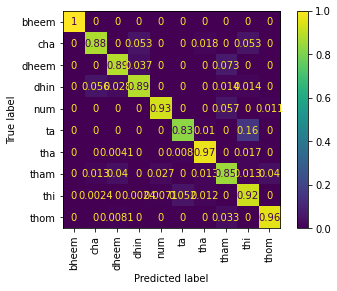

In [ ]:
# Our classifier is a "pipeline": scaling followed by KNN
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

# Fit all stages of the pipeline to our training data
clf.fit(X_train, y=y_train)

# How well does our 1-Nearest neighbor model work?
y_pred = clf.predict(X_test)

# Compare our predictions to the true labels in y_test
report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

# Finally, plot a confusion matrix showing how mistakes are distributed
plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

## Feature visualization

In [ ]:
### How to visualize features using metric learning https://github.com/bmcfee/ismir2020-metric-learning
# scikit-learn provides Linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Finally, umap will let us map high-dimensional data down to 2-d for plotting
import umap

We visualize the data by applying a transformation using UMAP from a high dimensional space to a low dimensional space. Similarly to the PCA reduction, the output axes do not hold any specific meaning.

In [ ]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll apply all but the last stage (KNN classifier) of our pipeline to the data.
# In this case, we just have one previous stage, which does feature normalization.
# This will change in subsequent examples.

X_train_transformed = clf[:-1].transform(X_train)
X_test_transformed = clf[:-1].transform(X_test)

# Fit on the transformed data, and then transform the test data
embed = reducer.fit_transform(X_train_transformed)
embed_test = reducer.transform(X_test_transformed)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In the plot the different classes are plotted with different colors, while the train and test datasets are denoted by x or circles.
If the test and training data of the same color appear near each other in the visualization, then nearest neighbor classification should work well.

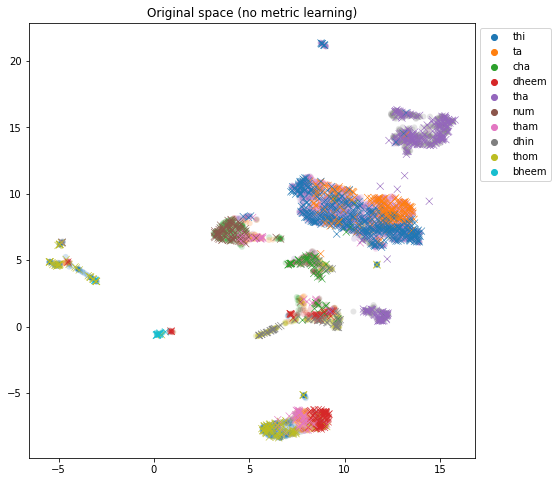

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Original space (no metric learning)');

## Linear projection of features

We use Linear Discriminant Analysis to better separate the classes by learning a 9-dimensional projection of the features. 

[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing lineardiscriminantanalysis, total=   0.1s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
              precision    recall  f1-score   support

       bheem       1.00      1.00      1.00        16
         cha       0.90      0.82      0.86        57
       dheem       0.95      0.91      0.93        82
        dhin       0.89      0.96      0.93        71
         num       1.00      0.95      0.98        88
          ta       0.86      0.86      0.86       195
         tha       0.99      0.94      0.97       241
        tham       0.81      0.85      0.83        75
         thi       0.91      0.94      0.93       423
        thom       0.95      0.95      0.95       123

    accuracy                           0.92      1371
   macro avg       0.93      0.92      0.92      1371
weighted avg       0.92      0.92      0.92      1371



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


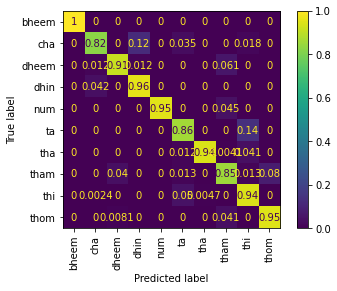

In [ ]:
clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(), KNeighborsClassifier(n_neighbors=1), verbose=True)
clf.fit(X_train, y=y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

Let's visualize the results: 

In [ ]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll fit the umap embedding on the data after applying our learned transformation
embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

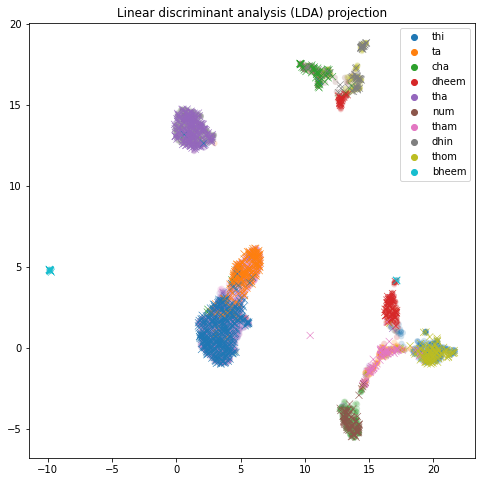

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=y_train_text, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=y_test_text, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Linear discriminant analysis (LDA) projection');

The projection learned by LDA tells us the weight assigned to each of the training features. 

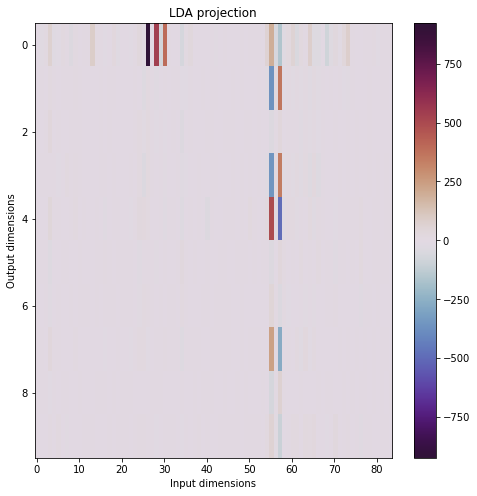

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[1][1]
weights = model.coef_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax)
ax.grid(False)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='LDA projection');

Which features are given more importance? 

In [ ]:
for i in range(len(weights)):
  print(data.columns[:-1][weights[0]>100])

Index(['loudness_ebu128.momentary.mean', 'loudness_ebu128.short_term.mean',
       'spectral_decrease.stdev'],
      dtype='object')
Index(['loudness_ebu128.momentary.mean', 'loudness_ebu128.short_term.mean',
       'spectral_decrease.stdev'],
      dtype='object')
Index(['loudness_ebu128.momentary.mean', 'loudness_ebu128.short_term.mean',
       'spectral_decrease.stdev'],
      dtype='object')
Index(['loudness_ebu128.momentary.mean', 'loudness_ebu128.short_term.mean',
       'spectral_decrease.stdev'],
      dtype='object')
Index(['loudness_ebu128.momentary.mean', 'loudness_ebu128.short_term.mean',
       'spectral_decrease.stdev'],
      dtype='object')
Index(['loudness_ebu128.momentary.mean', 'loudness_ebu128.short_term.mean',
       'spectral_decrease.stdev'],
      dtype='object')
Index(['loudness_ebu128.momentary.mean', 'loudness_ebu128.short_term.mean',
       'spectral_decrease.stdev'],
      dtype='object')
Index(['loudness_ebu128.momentary.mean', 'loudness_ebu128.short_term.